<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from PIL import Image
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output

%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
seed = 55
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnnbenchmark = True
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
!pip install gdown

In [ ]:
# скачиваем датасет картинок уже уменьшенных до размера 128х128
import gdown
# url='https://drive.google.com/uc?id=1QG7IdxVNfr1Rb_IjaBs1sFILSYi-jG1J&export=download'
url='https://drive.google.com/uc?id=13fCP6Vf8ZcW2lkC-QZxhpaLxPUc_R3hT&export=download'
output = 'face_dataset_big.zip'
gdown.download(url, output, quiet=True)

In [ ]:
!mkdir face_dataset_big; unzip -qq face_dataset_big.zip -d ./face_dataset_big/dataset

In [ ]:
!rm -rf face_dataset_big/dataset/__MACOSX/

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

In [ ]:
# folder_name = "drive/MyDrive/CV/small_dataset/"
folder_name = "face_dataset_big/"
batch_size = 64
train_ds = ImageFolder(folder_name, 
                       transform=tt.Compose([
                                             tt.ToTensor(),
                                             tt.Normalize((0.5, 0.5, 0.5), 
                                                          (0.5, 0.5, 0.5))]))

train_dl_big = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
# def get_dataloader(image_size, batch_size):
#     """
#     Builds dataloader for training data.
#     Use tt.Compose and tt.Resize for transformations
#     :param image_size: height and wdith of the image
#     :param batch_size: batch_size of the dataloader
#     :returns: DataLoader object 
#     """
#     train_ds = ImageFolder("face_dataset_small/", 
#                            transform=tt.Compose([tt.Resize(image_size),
#                                                tt.CenterCrop(image_size),
#                                                tt.ToTensor(),
#                                                tt.Normalize((0.5, 0.5, 0.5), 
#                                                             (0.5, 0.5, 0.5))]))
#   # TODO: resize images, convert them to tensors and build dataloader
#     return DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)

In [ ]:
# image_size = 128

# train_dl_small = get_dataloader(image_size, batch_size)
# # #TODO: build dataloader and transfer it to device

In [ ]:
def denorm(img_tensors):
    return img_tensors * 0.5 + 0.5

In [ ]:
def show_images(images, nmax=64):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    plt.show()

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [ ]:
show_batch(train_dl_big)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
latent_dim = 512

In [ ]:
class Discrimimator(nn.Module):
    def __init__(self):
        super(Discrimimator, self).__init__()

        self.disc = nn.Sequential(
            # 3 x 128 x 128
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 32 x 64 x 64

            nn.Conv2d(32, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 32 x 32

            nn.Conv2d(128, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            # out: 512 x 8 x 8

            nn.Flatten(),

            nn.Linear(in_features=512*8*8, out_features=64*4*4),
            nn.Linear(in_features=64*4*4, out_features=1),
            nn.Sigmoid()
        )


    def forward(self, x):
        return self.disc(x)

In [ ]:
discriminator = Discrimimator().to(device)

In [ ]:
class Reshape(nn.Module):
    def __init__(self, *shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.latent_dim = latent_dim
        self.gen = nn.Sequential(
#             latent_dim x 1 x 1
            nn.Flatten(),
            
            nn.Linear(in_features=self.latent_dim, out_features=1024),
            nn.Linear(in_features=1024, out_features=4096),

            Reshape(-1, 4, 32, 32),

            # 4 x 32 x 32
            nn.ConvTranspose2d(4, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # 64 x 64 x 64
            nn.ConvTranspose2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # 128 x 64 x 64
            nn.ConvTranspose2d(128, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # 512 x 64 x 64
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # 512 x 128 x 128
            nn.ConvTranspose2d(512, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.3, inplace=True),

            # 64 x 128 x 128
            nn.ConvTranspose2d(64, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.3, inplace=True),

            # 16 x 128 x 128
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.gen(x)

In [ ]:
generator = Generator(latent_dim).to(device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
# xb = torch.randn(batch_size, latent_dim, 1, 1) 
# fake_images = generator(xb.to(device))
# print(fake_images.shape)
# show_images(fake_images.cpu())

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
fixed_latent = torch.randn(64, latent_dim, 1, 1, device=device)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
        plt.show()

In [ ]:
lr = 0.0001
epochs = 300

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

optimizer = {
    "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                      lr=lr, betas=(0.5, 0.999)),
    "generator": torch.optim.Adam(model["generator"].parameters(),
                                  lr=lr, betas=(0.5, 0.999))
    }

In [ ]:
def noise_targets(target, real_targets=True):
    if real_targets:
        target = target - torch.clamp(torch.randn_like(target), min=0, max = 0.4)
        return target
    else:
        target = target + torch.clamp(torch.randn_like(target), min=0, max = 0.4)
        return target

In [ ]:
def plot_losses(disc_loss, gen_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(disc_loss, '-')
    plt.plot(gen_loss, '-')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Discriminator', 'Generator'])
    plt.title('Losses');
    plt.show()
    
def plot_scores(disc_score, gen_score):
    plt.figure(figsize=(10, 6))
    plt.plot(disc_score, '-')
    plt.plot(gen_score, '-')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.legend(['Real', 'Fake'])
    plt.title('Scores');
    plt.show()

In [ ]:
def fit(model, criterion, epochs, dataset):
    # TODO: build optimizers and train your GAN
    model["discriminator"].train()
    model["generator"].train()

    torch.cuda.empty_cache()
    torch.cuda.memory.empty_cache()
    
    # losses
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    for epoch in range(epochs):
        loss_g_per_epoch = []
        loss_d_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []

        for real_images, _ in tqdm(dataset):
            optimizer["discriminator"].zero_grad()

#             image_noise = torch.randn_like(real_images, device=device)
            real_preds = model["discriminator"](real_images.to(device))
            real_targets = noise_targets(torch.ones(real_images.size(0), 1, device=device), True)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = noise_targets(torch.zeros(fake_images.size(0), 1, device=device), False)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        
        with torch.no_grad():
            gen_fake_image = model["generator"](fixed_latent.to(device))
            show_images(gen_fake_image.cpu())
            plot_losses(losses_d, losses_g)
            plot_scores(real_scores, fake_scores)
            
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
        
        # Save generated images
        if epoch == epochs - 1:
            save_samples(epoch+1, fixed_latent, show=False)

        del real_images, fake_images, gen_fake_image
    
        torch.save(model["discriminator"], "./discriminator_learned.pth")
        torch.save(model["generator"], "./generator_learned.pth")
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
history = fit(model, criterion, epochs, train_dl_big)

*Картинка процесса обучения*
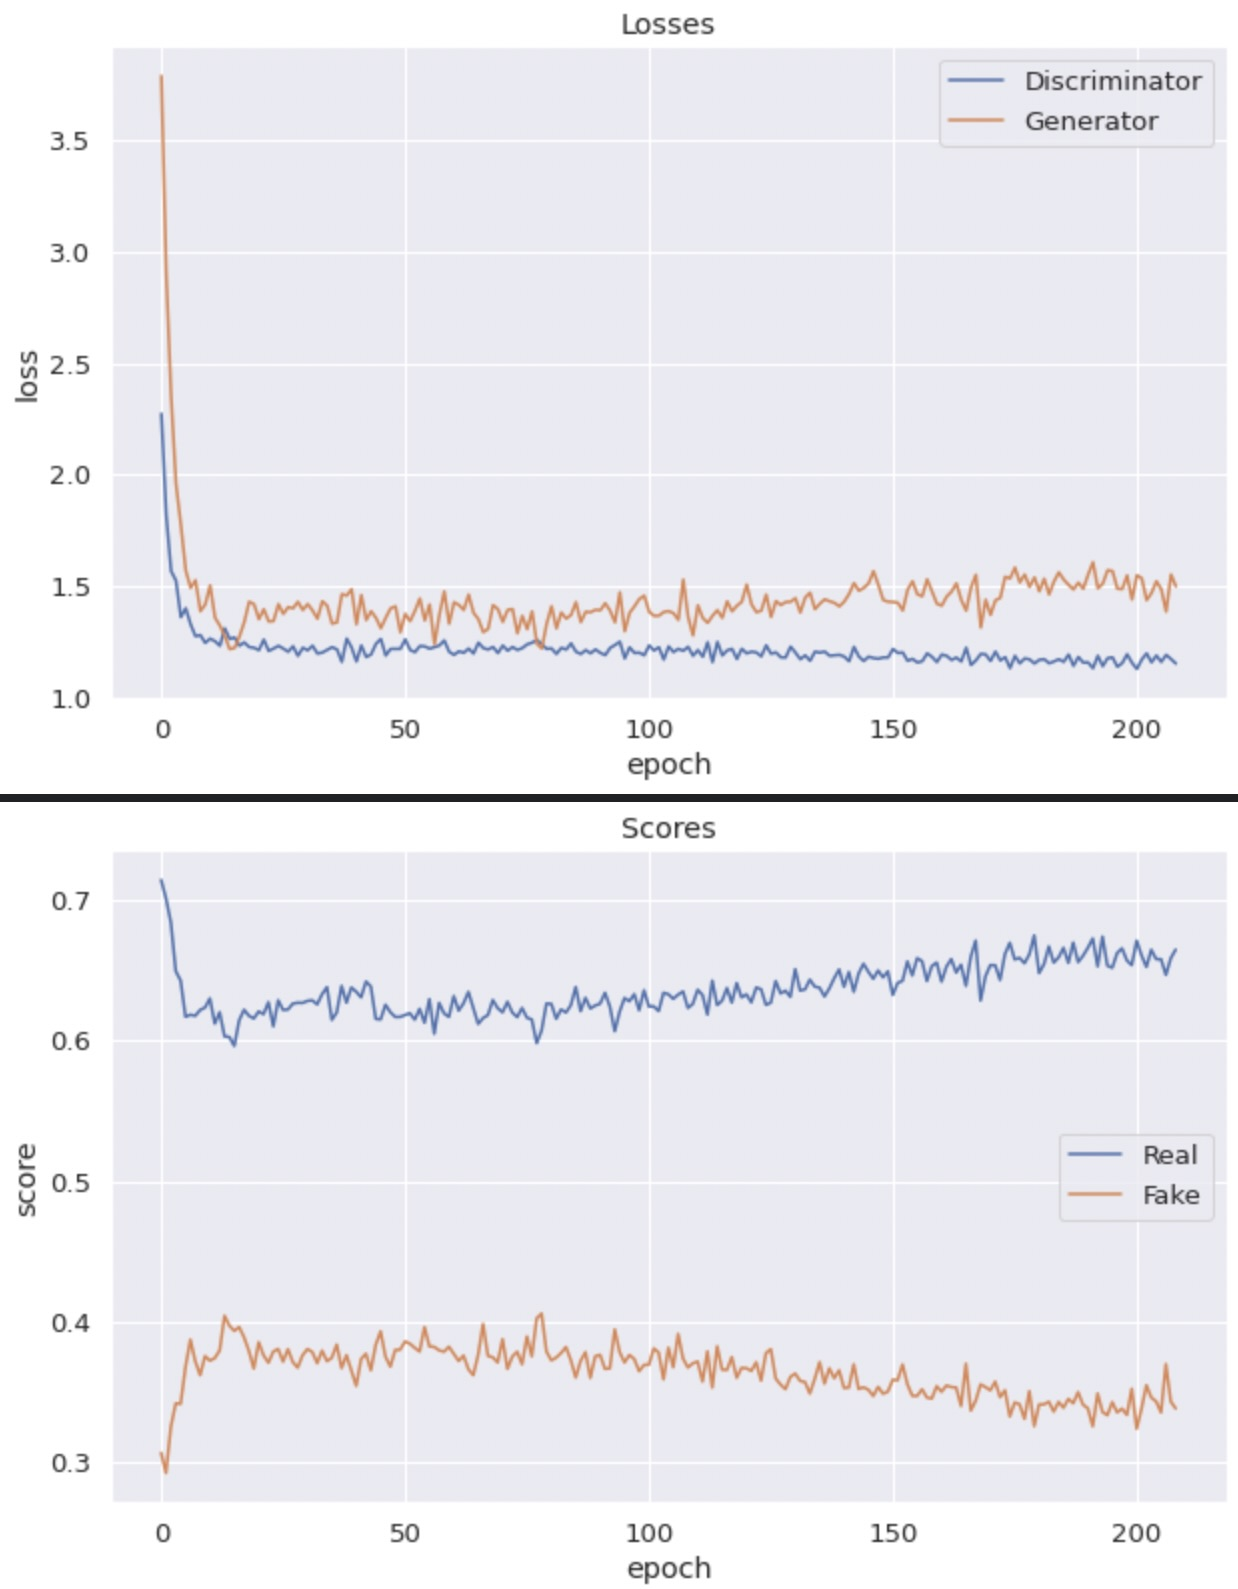

In [ ]:
# losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# plt.figure(figsize=(15, 6))
# plt.plot(losses_d, '-')
# plt.plot(losses_g, '-')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.legend(['Discriminator', 'Generator'])
# plt.title('Losses');

In [ ]:
# plt.figure(figsize=(15, 6))
# plt.plot(real_scores, '-')
# plt.plot(fake_scores, '-')
# plt.xlabel('epoch')
# plt.ylabel('score')
# plt.legend(['Real', 'Fake'])
# plt.title('Scores');

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

**Эти графики похожи на те, что были на семинаре, только процесс обучения идет не так быстро, из-за большего размера входных картинок и более сложной архитектуры моделей.**



## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
# model["discriminator"] = torch.load("./discriminator_learned (2).pth")
model["generator"] = torch.load("./generator_learned.pth")

In [ ]:
n_images = 64
fixed_latent = torch.randn(n_images, latent_dim, 1, 1, device=device)
with torch.no_grad():
    model["generator"].eval()
    gen_fake_image = model["generator"](fixed_latent.to(device))
    show_images(gen_fake_image.cpu(), nmax=n_images)

Пример генерации лиц(Картинка)
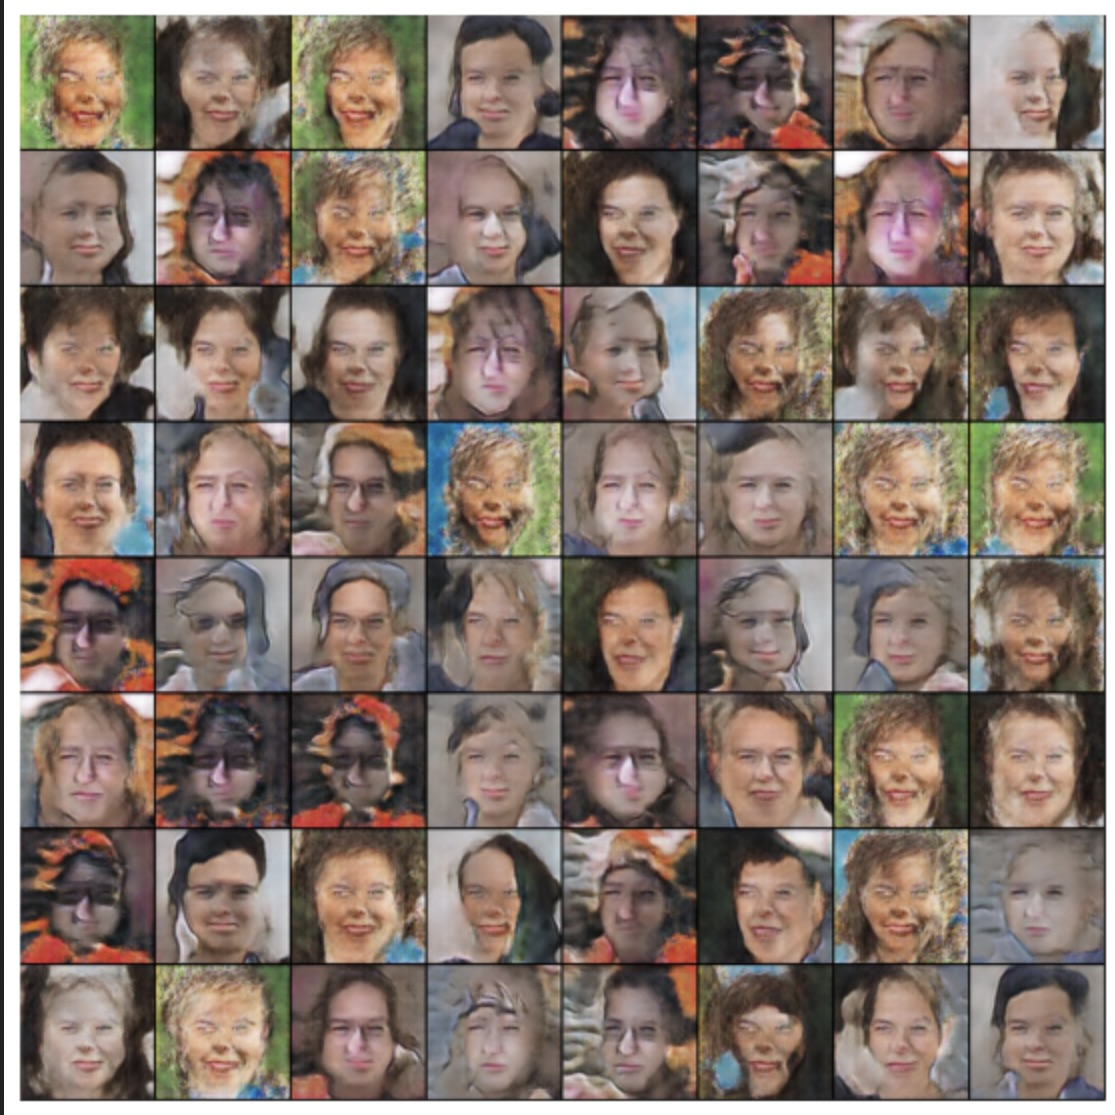

In [ ]:
# def show_images(generated):
#   # TODO: show generated images
#   pass

Как вам качество получившихся изображений?

1. Лица в полученных изображениях проглядываются, правда некоторые примеры очень непонятные.
2. Такое невысокое качество генерации может быть связано с небольшой обучающей выборкой(2182 картинки), небольшим временем обучения. Это было сделано в угоду экономии времени

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
num_images = 500
fixed_latent = torch.randn(num_images, latent_dim, 1, 1)
fixed_latent_dl = DataLoader(dataset=fixed_latent, batch_size=64, shuffle=False)
x_fake_images = []
with torch.no_grad():
    model["generator"].eval()
    for lat_vec in fixed_latent_dl:
        x_fake = model['generator'].to(device)(lat_vec.to(device)).cpu().detach().numpy()
        x_fake_images.append(x_fake)
# x_fake = model['generator'].cpu()(fixed_latent).cpu().detach().numpy()
x_fake_images = np.concatenate(x_fake_images, 0)
y_fake = np.zeros((num_images, 1))

In [ ]:
x_real = np.zeros((num_images, 3, 128, 128))
y_real = np.ones_like(y_fake)

for idx, item in enumerate(train_ds):
    if idx == num_images:
        break
    x_real[idx] = item[0]

In [ ]:
x_data = np.vstack((x_real, x_fake_images)).reshape(2*num_images, -1)
y_data = np.vstack((y_real, y_fake))

In [ ]:
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
loo = LeaveOneOut()
loo.get_n_splits(x_data)

accuracy = 0
num_iter = 0
for train_index, test_index in tqdm(loo.split(x_data)):
    neigh = KNeighborsClassifier(n_neighbors=1)

    X_train, X_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    neigh.fit(X_train, y_train.ravel())
    accuracy += (neigh.predict(X_test) == y_test)
    num_iter += 1
print(f"LOO accuracy is {(accuracy / num_iter).item()}")

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

1. С учетом не самого глубокого обучения (209 эпох на 2182 картинках) получили точность LOO 0.68, что в таких условиях достаточно хорошо. 

2. В идеальном случае хотелось бы получить точность 0.5 в таком случае дискриминатор не понимает какое изображение сгенерировано, а какое реальное, поэтому "подбрасывает монетку" и делает выбор. 



### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(x_data)
X_embedded.shape

In [ ]:
import plotly.express as px

In [ ]:
fig = px.scatter(x=X_embedded[:,0], y=X_embedded[:,1], color=y_data.squeeze().astype(str))
fig.update_layout(
    autosize=False,
    width=700,
    height=700
)
fig.show()

*Картинка распределения*
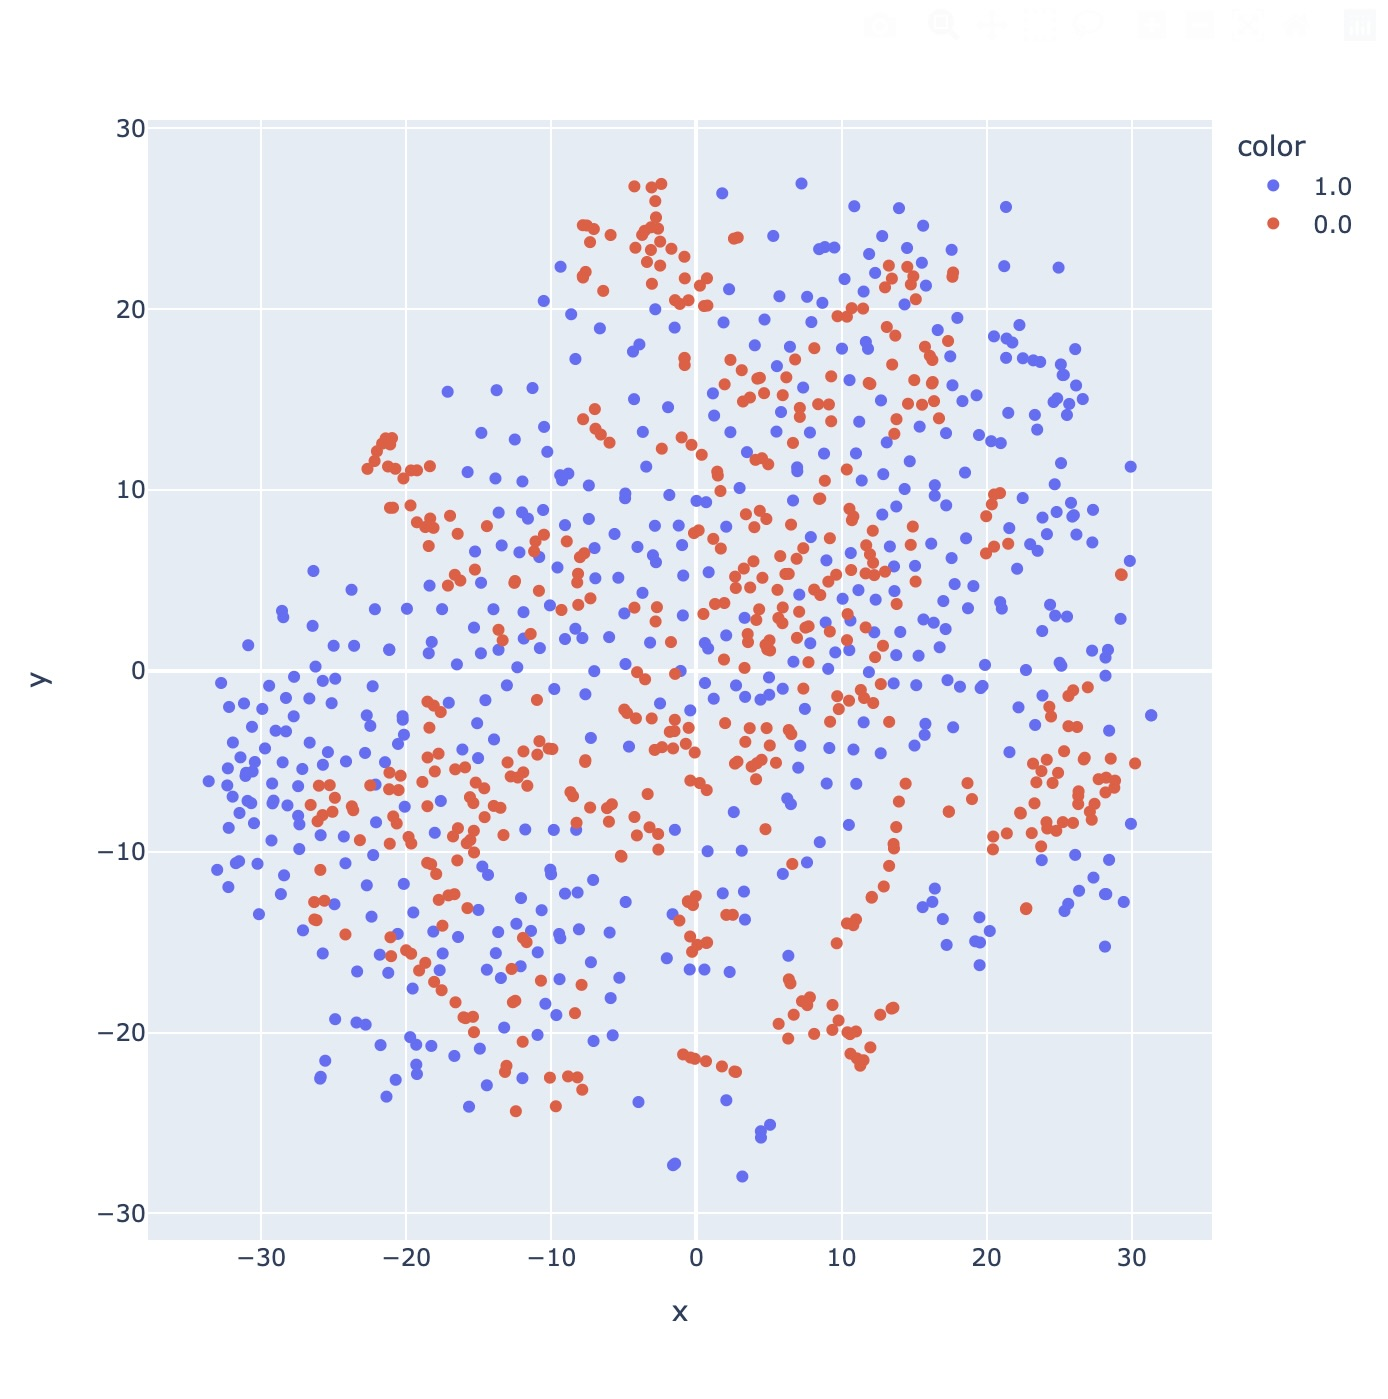

Прокомментируйте получившийся результат:

На глаз видно, что картинки довольно неплохо перемешаны. Есть небольшие области по краям, где преимущественно y_real, но в общим целом получилось хорошо